# Mid-Sagittal plane algorithm

### Import relevant packages

In [143]:
import joblib
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import center_of_mass
from scipy.optimize import minimize
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator
from joblib import Parallel, delayed, dump, load
from matplotlib.widgets import Slider
import ipywidgets as widgets
from matplotlib.lines import Line2D
import time
from scipy import ndimage
import json
import skimage
from scipy.spatial import ConvexHull, distance
import seaborn as sns
import pickle
import os
import gzip
from scipy.spatial.transform import Rotation as R

## Data Reading

In [144]:
def load_nifti_file(file_path):
    """
    Load a NIfTI file and return the image data.
    
    Parameters:
    file_path (str): Path to the NIfTI file.
    
    Returns:
    numpy.ndarray: The image data.
    """
    import nibabel as nib

    nifti_img = nib.load(file_path)
    img_data = nifti_img.get_fdata()
    voxel_size = nifti_img.header.get_zooms()
    
    return img_data, voxel_size

def open_gzip_file(gzip_file_path):
    """
    Open a gzip file and return its content.

    Parameters:
    gzip_file_path (str): The path to the gzip file.

    Returns:
    bytes: The content of the gzip file.
    """
    try:
        with gzip.open(gzip_file_path, 'rb') as f_in:
            file_content = f_in.read()
        return file_content
    except Exception as e:
        print(f'Error opening {gzip_file_path}: {e}')
        return None
    
def get_image_and_voxel_size_from_gzip(gzip_file_path):
    """
    Get the image array and voxel size from a gzipped NIfTI file.

    Parameters:
    gzip_file_path (str): Path to the gzipped NIfTI file.

    Returns:
    tuple: The image array and voxel size.
    """

    file_content = open_gzip_file(gzip_file_path)
    if file_content is not None:
        with open('temp_nifti.nii', 'wb') as temp_file:
            temp_file.write(file_content)

        # 🔹 Debugging: Check if the file was actually written
        file_size = os.path.getsize('temp_nifti.nii')
        if file_size == 0:
            print(f"❌ Error: 'temp_nifti.nii' was written but is empty! ({gzip_file_path})")
            return None, None

        img_data, voxel_size = load_nifti_file('temp_nifti.nii')
        os.remove('temp_nifti.nii')  # Remove temp file after reading
        
        return img_data, voxel_size
    else:
        print(f"❌ Error: Failed to read file content from '{gzip_file_path}'")
        return None, None
    
def load_patient_structures(patient_folder: str, structure_names=None):
    """
    Searches the patient folder (recursively) for NIfTI files matching the
    specified structure names, loads each file, transposes the image array,
    and returns a mapping from structure name to (image_array, voxel_size).

    Parameters
    ----------
    patient_folder : str
        Path to the patient folder (numeric name).
    structure_names : list of str, optional
        List of expected structure names (without extension). Defaults to:
        ['Image', 'GTVp', 'Body', 'Mandible', 'Spinal Cord'].
    Returns
    -------
    dict
        Keys are structure names from structure_names that were found,
        values are tuples (img_array, voxel_size).
    """
    if structure_names is None:
        structure_names = ['Image', 'GTVp', 'Body', 'Mandible', 'Spinal Cord']

    struct_dict = {}
    for root, _, files in os.walk(patient_folder):
        for f in files:
            # Only NIfTI files
            if not (f.endswith('.nii.gz') or f.endswith('.nii')):
                continue

            name_part = f
            
            # Entferne Extension
            if name_part.endswith('.nii.gz'):
                base = name_part[:-7]
            else:
                base = name_part[:-4]

            # Vergleiche mit erwarteten Struktur-Namen (case-insensitive)
            for struct_name in structure_names:
                if base.lower() == struct_name.lower():
                    file_path = os.path.join(root, f)
                    try:
                        if f.endswith('.nii.gz'):
                            img, voxel_size = get_image_and_voxel_size_from_gzip(file_path)
                        else:
                            img, voxel_size = load_nifti_file(file_path)
                    except Exception as e:
                        logging.error(f"Error loading '{struct_name}' from {file_path}: {e}")
                        continue

                    if img is not None:
                        #img = np.transpose(img, (1, 0, 2))
                        struct_dict[struct_name] = (img, voxel_size)
                        print(f"Loaded '{struct_name}' from {file_path}")
                    break
    return struct_dict

## Image processing

In [145]:
def mask_via_threshold(ct_image, HU_range=(300, 1500)):
    
    bone_mask = np.zeros_like(ct_image)
    lower_bound, upper_bound = HU_range
    bone_mask[(ct_image >= lower_bound) & (ct_image <= upper_bound)] = 1

    return bone_mask

def get_nonzero_slice_range(image_data, slice_dir_idx = 2):
    
    if image_data.ndim != 3:
        raise ValueError("image_data must be a 3D array.")
    if slice_dir_idx not in (0, 1, 2):
        raise ValueError("slice_dir_indx must be 0, 1, or 2.")
    
    # Determine which axes to collapse for the nonzero test.
    if slice_dir_idx == 0:
        collapsed = np.any(image_data, axis=(1, 2))
    elif slice_dir_idx == 1:
        collapsed = np.any(image_data, axis=(0, 2))
    else:  # slice_dir_indx == 2
        collapsed = np.any(image_data, axis=(0, 1))
    
    nonzero_indices = np.nonzero(collapsed)[0]
    if nonzero_indices.size == 0:
        raise ValueError("No non-zero slices found in the specified direction.")
    
    start = int(nonzero_indices[0])
    end = int(nonzero_indices[-1])
    
    return start, end

## Parametrization

In [146]:
def vector_to_angles(vector):
    
    x, y, z = vector

    # Calculate the distance from the origin
    R = np.linalg.norm(vector)

    # Calculate the distance from the origin in xy plane
    r = np.sqrt(x**2 + y**2)

    # Calculate the angle in the xy plane with respect to the x-axis
    azimuthal = np.arctan2(y, x)

    # Calculate the angle in the xz plane with respect to the z-axis
    polar = np.arctan2(r, z)

    return np.array([azimuthal, polar, R])

def angles_to_vector(azimuthal, polar, R):
    
    x = R * np.sin(polar) * np.cos(azimuthal)
    y = R * np.sin(polar) * np.sin(azimuthal)
    z = R * np.cos(polar)
    
    return np.array([x, y, z])

def generate_normal(theta: float, phi: float) -> np.ndarray:
    return np.array([
        np.sin(phi) * np.cos(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(phi)
    ])

## Objective function


In [147]:
def compute_signed_distances(params_array, image):
    
    azimuthal, polar, L = params_array

    indices_image = np.array(np.nonzero(image)).T

    indices_coord_syst = np.stack([
        indices_image[:,1],
        indices_image[:,0],
        indices_image[:,2]
    ], axis=1)

    # Unit normal in mathematical spherical convention
    n = np.array([
        np.sin(polar) * np.cos(azimuthal),
        np.sin(polar) * np.sin(azimuthal),
        np.cos(polar)
    ])

    d = indices_coord_syst.dot(n) - L

    return d, n, indices_coord_syst, indices_image

def huber_loss(diff, delta=1400):
    
    h_loss = np.where(np.abs(diff) <= delta, 0.5 * diff**2,
                    delta * (np.abs(diff) - 0.5 * delta))
    return h_loss

def compute_objective(params_array, image, interpolator_intensity):
    
    d, n, indices_coord_syst, indices_image = compute_signed_distances(params_array, image)
    N = len(d)
    x_m_coord_syst = indices_coord_syst - 2 * d[:, None] * n[None, :]
    x_m_image = np.array([x_m_coord_syst[:, 1], x_m_coord_syst[:, 0], x_m_coord_syst[:, 2]]).T
    I_m = interpolator_intensity(x_m_image)
    I_orig = image[indices_image[:, 0], indices_image[:, 1], indices_image[:, 2]]
    diff = I_orig - I_m
    f = (1.0 / N) * np.sum(huber_loss(diff, delta=1400))
    return f

## Parameter Initialization

In [148]:
def parameter_initialization(image, bone, output_path, interpolator_intensity,
                         azimuthal_deg=0, polar_deg=0, uncertainty = 90,
                         initialization_steps=10):
    
    print("Starting parameter initialization...")
    start = time.time()
    com = center_of_mass(image)
    com = np.array([com[1], com[0], com[2]])
    
    # Define angular search ranges (in radians)
    azimuthal_rad = np.deg2rad(azimuthal_deg)
    polar_rad = np.deg2rad(polar_deg)
    delta = np.deg2rad(uncertainty)
    azimuthal_angles = np.linspace(azimuthal_rad - delta, azimuthal_rad + delta, initialization_steps)
    polar_angles = np.linspace(polar_rad - delta, polar_rad + delta, initialization_steps)
    print(f"Azimuthal angles: {np.rad2deg(azimuthal_angles)}")
    print(f"Polar angles: {np.rad2deg(polar_angles)}")
    
    os.makedirs(output_path, exist_ok=True)
    mse_array_file = os.path.join(output_path, f"Initialization_obj_fun.npy")
    plane_params_file = os.path.join(output_path, f"Initialization_plane_params.npy")
    
    if not (os.path.exists(mse_array_file) and os.path.exists(plane_params_file)):
        φ, θ = np.meshgrid(polar_angles, azimuthal_angles, indexing='ij')
        n = generate_normal(θ, φ)
        L = np.tensordot(n, com, axes=([0],[0]))
        planes = np.stack([θ.ravel(), φ.ravel(), L.ravel()], axis=1)
        mse_array = np.array([compute_objective(p, bone, interpolator_intensity) for p in planes])
        # for parameter in planes:
        #     plot_middle_slice_with_planes(image, [parameter], com = com, title = f"parameters {np.rad2deg(parameter[0]):.2f} {np.rad2deg(parameter[1]):.2f} {parameter[2]:.2f}")
        np.save(mse_array_file, mse_array)
        np.save(plane_params_file, planes)
    else:
        mse_array = np.load(mse_array_file)
        planes    = np.load(plane_params_file)
    #plot_mse_heatmap(azimuthal_angles, polar_angles, mse_array)
    best_mse_index = np.argmin(mse_array)
    best_params = planes[best_mse_index]
    end = time.time()
    print(f"Time taken for initialization: {end - start:.2f} seconds")
    return best_params, mse_array[best_mse_index]

def plot_mse_heatmap(azimuthal_angles, polar_angles, mse_array):
    """
    Plots a 2D heatmap of MSE over the (θ, φ) grid.

    Parameters
    ----------
    azimuthal_angles : 1D array, shape (T,)
        The θ values in radians (azimuthal).
    polar_angles : 1D array, shape (P,)
        The φ values in radians (polar).
    mse_array : 1D array, shape (P*T,)
        The MSE values corresponding to each (θ, φ) pair, in row-major order
        matching np.meshgrid(..., indexing='ij').ravel().

    """
    P = len(polar_angles)
    T = len(azimuthal_angles)

    # reshape back to (φ, θ) grid
    mse_2d = mse_array.reshape(P, T)

    # convert to degrees for axis labeling
    theta_deg = np.rad2deg(azimuthal_angles)
    phi_deg   = np.rad2deg(polar_angles)

    # create a mesh for pcolormesh
    TH, PH = np.meshgrid(theta_deg, phi_deg)

    plt.figure(figsize=(8, 6))
    plt.pcolormesh(TH, PH, mse_2d, shading='auto', cmap='viridis', vmin = np.min(mse_2d), vmax = np.min(mse_2d) + 10000)
    plt.colorbar(label='MSE')
    plt.xlabel('Azimuthal angle θ (°)')
    plt.ylabel('Polar angle φ (°)')
    plt.title('MSE Heatmap over θ–φ Grid')
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.show()

## Optimization

In [149]:
def optimize_plane(initial_params_array, image, interpolator_intensity):

    objective_value_list = []
    params_list = []

    def callback(xk):
        f_val = compute_objective(xk, image, interpolator_intensity)
        objective_value_list.append(f_val)
        params_list.append(xk.copy())

    res = minimize(compute_objective, x0=initial_params_array, args=(image, interpolator_intensity),
                   method='BFGS', jac=None, callback=callback)
    params_list.append(res.x.copy())
    objective_value_list.append(res.fun)

    res.objective_value_list = objective_value_list
    res.params_list = params_list

    return res

## Verification Plots

In [150]:
def plot_planes_on_middle_slice(image, plane_params_list, title='Middle Slice with Planes', output_path=None):
    # middle slice
    H, W, D = image.shape
    z0 = D // 2
    slice_img = image[:, :, z0]

    # build grid for contour
    y = np.arange(H)
    x = np.arange(W)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(slice_img, cmap='gray', origin='lower')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    for (theta, phi, L) in plane_params_list:
        # normal
        nx = np.sin(phi) * np.cos(theta)
        ny = np.sin(phi) * np.sin(theta)
        nz = np.cos(phi)
        # right‐hand side constant
        C = L - nz * z0
        # define F(x,y) = nx*x + ny*y - C = 0
        F = nx * X + ny * Y - C

        ax.contour(X, Y, F, levels=[0], colors='red')

    plt.show()
    plt.savefig(os.path.join(output_path, 'plane_middle_slice.png'), dpi=300)

## Scrollable Widget

In [151]:
def sample_random_points(coords, distances, n_points):
    """
    Randomly sample a subset of points from the coordinate array and their corresponding distances.
    
    Parameters
    ----------
    coords : numpy.ndarray
        A 2D array of shape (N, 3) (or any shape where the first dimension is the number of points)
        containing the positions of the voxels.
    distances : numpy.ndarray
        A 1D array of length N containing the corresponding signed distances.
    n_points : int
        The number of random points to sample.
        
    Returns
    -------
    sampled_coords : numpy.ndarray
        A 2D array containing the randomly sampled coordinates.
    sampled_distances : numpy.ndarray
        A 1D array containing the distances corresponding to the sampled coordinates.
    """
    if n_points > len(distances):
        n_points = len(distances)
    # Randomly select n_points indices from the available points.
    indices = np.random.choice(len(distances), size=n_points, replace=False)
    sampled_coords = coords[indices]
    sampled_distances = distances[indices]
    return sampled_coords, sampled_distances

def display_scrollable_slices_with_plane(image, gtv_mask, body_mask=None, mandible_mask=None, spinal_cord_mask=None,
                              plane_coeffs_list=[], optimization_methods_list=[], points = None, distances = None):
    """
    Display an interactive widget to scroll through slices of the 3D image (in two views) with
    overlays of masks and plane contours.
    
    Parameters
    ----------
    image : numpy.ndarray
        The 3D image data.
    gtv_mask : numpy.ndarray
        The 3D primary GTV mask (mandatory).
    body_mask : numpy.ndarray, optional
        The 3D body mask.
    mandible_mask : numpy.ndarray, optional
        The 3D mandible mask.
    spinal_cord_mask : numpy.ndarray, optional
        The 3D spinal cord mask.
    plane_coeffs_list : list
        List of plane coefficients, where each is a tuple/list (theta, phi, L).
    optimization_methods_list : list
        List of method names corresponding to each plane, used for the legend.
    """
    num_slices = image.shape[2]
    plane_colors = ['red', 'purple', 'cyan']
    
    # Calculate center of mass from body_mask if provided.
    if body_mask is not None:
        com = center_of_mass(body_mask)
        # Swap first two coordinates to match image orientation.
        com = (com[1], com[0], com[2])
    else:
        com = None
    #points, distances = sample_random_points(points, distances, 15)

    def view_slice_axial(slice_index):
        fig, ax = plt.subplots(figsize=(10, 10))
        # Display the grayscale image.
        ax.imshow(image[:, :, slice_index], cmap='gray', interpolation='none')
        
        if points is not None:
            mask = points[:, 2] == slice_index
            filtered_coords = points[mask]
            filtered_distances = distances[mask]
            for (x, y, z), dist in zip(filtered_coords, filtered_distances):
                plt.plot(x, y, 'ro', markersize=2)
                plt.text(x, y, f"{round(dist,1)}", color='green', fontsize=6)
                
        # Overlay the mandatory GTV mask.
        ax.contour(gtv_mask[:, :, slice_index], colors='yellow', linewidths=1)
        
        # Overlay optional masks if available.
        if body_mask is not None:
            ax.contour(body_mask[:, :, slice_index], colors='orange', linewidths=1)
        if mandible_mask is not None:
            ax.contour(mandible_mask[:, :, slice_index], colors='blue', linewidths=1)
        if spinal_cord_mask is not None:
            ax.contour(spinal_cord_mask[:, :, slice_index], colors='green', linewidths=1)
            
        # Overlay each plane contour.
        for idx, coeffs in enumerate(plane_coeffs_list):
            A, B, C = angles_to_vector(coeffs[0], coeffs[1], coeffs[2])
            D = - np.dot([A, B, C], [A, B, C])
            # Avoid division by zero.
            C_val = C if C != 0 else 1e-6
            x = np.linspace(0, image.shape[1], 100)
            y = np.linspace(0, image.shape[0], 100)
            X, Y = np.meshgrid(x, y)
            contour = (-A * X - B * Y - D) / C_val
            ax.contour(X, Y, contour, levels=[slice_index],
                       colors=plane_colors[idx % len(plane_colors)], linewidths=1)
        
        # Build legend based on available overlays.
        legend_handles = [Line2D([0], [0], color='yellow', lw=2, label='GTVp')]
        if body_mask is not None:
            legend_handles.append(Line2D([0], [0], color='orange', lw=2, label='Body'))
        if mandible_mask is not None:
            legend_handles.append(Line2D([0], [0], color='blue', lw=2, label='Mandible'))
        if spinal_cord_mask is not None:
            legend_handles.append(Line2D([0], [0], color='green', lw=2, label='Spinal Cord'))
        for idx, coeffs in enumerate(plane_coeffs_list):
            if idx < len(optimization_methods_list):
                legend_handles.append(Line2D([0], [0], color=plane_colors[idx % len(plane_colors)],
                                              lw=2, label=optimization_methods_list[idx]))
        
        ax.legend(handles=legend_handles, loc='upper right')
        
        # Custom coordinate formatter for axial view.
        def format_coord(x, y):
            col = int(round(x))
            row = int(round(y))
            info = f"x={col}, y={row}, slice={slice_index}"
            if 0 <= row < gtv_mask.shape[0] and 0 <= col < gtv_mask.shape[1]:
                info += f", GTVp={gtv_mask[row, col, slice_index]}"
            if body_mask is not None and 0 <= row < body_mask.shape[0] and 0 <= col < body_mask.shape[1]:
                info += f", Body={body_mask[row, col, slice_index]}"
            if mandible_mask is not None and 0 <= row < mandible_mask.shape[0] and 0 <= col < mandible_mask.shape[1]:
                info += f", Mandible={mandible_mask[row, col, slice_index]}"
            if spinal_cord_mask is not None and 0 <= row < spinal_cord_mask.shape[0] and 0 <= col < spinal_cord_mask.shape[1]:
                info += f", Spinal Cord={spinal_cord_mask[row, col, slice_index]}"
            return info
        ax.format_coord = format_coord
        
        ax.axis('off')
        plt.show()

    # For coronal view, determine slice range along x direction.
    if body_mask is not None:
        start_slice, end_slice = get_nonzero_slice_range(body_mask, slice_dir_idx=0)
    else:
        start_slice = 0
        end_slice = image.shape[0] - 1

    def view_slice_coronal(slice_index):
        fig, ax = plt.subplots(figsize=(10, 10))
        # Display coronal view (slice along x axis).
        ax.imshow(image[slice_index, :, :], cmap='gray', interpolation='none')
        ax.contour(gtv_mask[slice_index, :, :], colors='yellow')
        if body_mask is not None:
            ax.contour(body_mask[slice_index, :, :], colors='orange')
        if mandible_mask is not None:
            ax.contour(mandible_mask[slice_index, :, :], colors='blue')
        if spinal_cord_mask is not None:
            ax.contour(spinal_cord_mask[slice_index, :, :], colors='green')
        
        for idx, coeffs in enumerate(plane_coeffs_list):
            A, B, C = angles_to_vector(coeffs[0], coeffs[1], coeffs[2])
            D = - np.dot([A, B, C], [A, B, C])
            B_val = B if B != 0 else 1e-6
            x = np.linspace(0, image.shape[0], 100)
            z = np.linspace(0, image.shape[2], 100)
            X, Z = np.meshgrid(x, z)
            contour = (-A * X - C * Z - D) / B_val
            ax.contour(Z, X, contour, levels=[slice_index], colors=plane_colors[idx % len(plane_colors)])
        
        # Build legend for coronal view.
        # legend_handles = [Line2D([0], [0], color='yellow', lw=2, label='GTVp')]
        # if body_mask is not None:
        #     legend_handles.append(Line2D([0], [0], color='orange', lw=2, label='Body'))
        # if mandible_mask is not None:
        #     legend_handles.append(Line2D([0], [0], color='blue', lw=2, label='Mandible'))
        # if spinal_cord_mask is not None:
        #     legend_handles.append(Line2D([0], [0], color='green', lw=2, label='Spinal Cord'))
        # for idx, coeffs in enumerate(plane_coeffs_list):
        #     if idx < len(optimization_methods_list):
        #         legend_handles.append(Line2D([0], [0], color=plane_colors[idx % len(plane_colors)], lw=2,
        #                                       label=optimization_methods_list[idx]))
        # ax.legend(handles=legend_handles, loc='upper right')
        
        ax.set_ylim(start_slice, end_slice)
        ax.axis('off')
        plt.show()

    # Interactive slider for axial (z) view.
    slice_slider_axial = widgets.IntSlider(min=0, max=num_slices-1, step=1, value=num_slices//2, description='Axial Slice')
    display(widgets.interact(view_slice_axial, slice_index=slice_slider_axial))
    
    # Interactive slider for coronal (x) view.
    slice_slider_coronal = widgets.IntSlider(min=start_slice, max=end_slice, step=1, value=(start_slice+end_slice)//2, description='Coronal Slice')
    display(widgets.interact(view_slice_coronal, slice_index=slice_slider_coronal))

def display_patient_overlay_structures(struct_dict, title="Overlay Structures"):
    """
    Creates an interactive widget that overlays structure contours over the main image.
    
    The main image is expected under the key "Image" and the primary GTV mask under "GTVp" in struct_dict.
    Other masks (e.g. "Body", "Mandible", "Spinal Cord") are optional. For each slice, the main image is
    displayed in grayscale and the available masks are overlaid as contours using predetermined colors.
    A legend is added for the masks that are present and a custom coordinate formatter shows the pixel 
    coordinates and the mask values when hovering over the image.
    
    Parameters
    ----------
    struct_dict : dict
        Dictionary mapping structure names to (image_array, voxel_size).
        Must contain keys "Image" and "GTVp".
    title : str, optional
        Title prefix for the displayed plot.
    """
    # Check that mandatory keys exist.
    if "Image" not in struct_dict:
        print("Main image (key 'Image') not found in the structure dictionary.")
        return
    if "GTVp" not in struct_dict:
        print("Primary GTV mask (key 'GTVp') not found in the structure dictionary.")
        return
    
    main_img, _ = struct_dict["Image"]
    gtv_img, _  = struct_dict["GTVp"]
    num_slices = main_img.shape[2]
    
    # Define a dictionary of colors for each structure.
    mask_colors = {
        "GTVp": "yellow",   # mandatory
        "Body": "red",
        "Mandible": "blue",
        "Spinal Cord": "green"
    }
    
    # Build list of optional mask keys that are present.
    optional_keys = []
    for key in ["Body", "Mandible", "Spinal Cord"]:
        if key in struct_dict and struct_dict[key] is not None:
            optional_keys.append(key)
    
    def view_slice(slice_index):
        fig, ax = plt.subplots(figsize=(8,8))
        # Display the main image in grayscale.
        ax.imshow(main_img[:, :, slice_index], cmap='gray', interpolation='none')
        
        # Overlay the mandatory GTV mask.
        ax.contour(gtv_img[:, :, slice_index], levels=[0.5], colors=mask_colors["GTVp"], linewidths=2)
        
        # Overlay optional masks if available.
        for key in optional_keys:
            mask_img, _ = struct_dict[key]
            # Only add the contour if there is any nonzero element.
            if np.any(mask_img[:, :, slice_index]):
                ax.contour(mask_img[:, :, slice_index], levels=[0.5], colors=mask_colors[key], linewidths=2)
        
        # Build legend using dummy handles.
        legend_handles = [Line2D([0], [0], color=mask_colors["GTVp"], lw=2, label="GTVp")]
        for key in optional_keys:
            legend_handles.append(Line2D([0], [0], color=mask_colors[key], lw=2, label=key))
        ax.legend(handles=legend_handles, loc='upper right')
        
        # # Set a custom coordinate formatter.
        # def format_coord(x, y):
        #     col = int(round(x))
        #     row = int(round(y))
        #     info = f"x={col}, y={row}, slice={slice_index}"
        #     # Always show value from GTVp.
        #     if 0 <= row < gtv_img.shape[0] and 0 <= col < gtv_img.shape[1]:
        #         info += f", GTVp={gtv_img[row, col, slice_index]}"
        #     # Append info for each optional mask.
        #     for key in optional_keys:
        #         mask_img, _ = struct_dict[key]
        #         if 0 <= row < mask_img.shape[0] and 0 <= col < mask_img.shape[1]:
        #             info += f", {key}={mask_img[row, col, slice_index]}"
        #     return info
        # ax.format_coord = format_coord
        
        ax.set_title(f"{title} - Slice {slice_index}")
        ax.axis('off')
        plt.show()
    
    slider = widgets.IntSlider(min=0, max=num_slices-1, step=1, value=num_slices//2, description='Slice')
    display(widgets.interact(view_slice, slice_index=slider))




## Optimization Pipeline

In [152]:
def MSP_pipeline(base_path, 
                      output_path,
                      structure_names = ["Image", "GTVp", "Mandible", "Spinal Cord", "Body"],
                      slice_axis = 2,
                      HU_range=[300, 1500],
                      slice_range=None,
                      azimuthal_deg=10,
                      polar_deg=10,
                      uncertainty=90,
                      initialization_steps=10):
                      
                    
    start_pipeline = time.time()
    list_best_plane_params = []
    list_obj_fun = []
    folders = sorted([d for d in os.listdir(base_path)], key=int)
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        print(f"Processing folder: {folder_path}")
        output_path_patient = os.path.join(output_path, folder)
        os.makedirs(output_path_patient, exist_ok=True)
        struct_dict = load_patient_structures(folder_path, structure_names)
        if struct_dict is None:
            print(f"No matching files found in {folder_path}. Skipping...")
            continue
        else:
            image = struct_dict.get("Image", (None,))[0]
            gtvp = struct_dict.get("GTVp", (None,))[0]
            if image is None or gtvp is None:
                print(f"Image or GTVp not found in {folder_path}. Skipping...")
                continue
            mandibula = struct_dict.get("Mandible", (None,))[0]
            spinalcord = struct_dict.get("Spinal Cord", (None,))[0]
            body = struct_dict.get("Body", (None,))[0]

        image = image.astype(np.int16)
        if body is not None:
            image = np.where(body == 1, image, -1000)
        if HU_range is None:
            HU_range = (300, 1500)
        bone_mask = mask_via_threshold(image, HU_range=(HU_range)).astype(np.uint16)
        bone_ct = image * bone_mask
        dental_fillings_mask = mask_via_threshold(image, HU_range=(HU_range[1], 5000)).astype(np.uint16)
        dental_bone_ct = HU_range[1] * dental_fillings_mask
        bone_ct = bone_ct + dental_bone_ct
        image = image * (1 - dental_fillings_mask) + dental_bone_ct
        
        start_slice, end_slice = get_nonzero_slice_range(gtvp, slice_dir_idx = slice_axis)
        if slice_range is not None:
            start_slice = slice_range[0]
            end_slice = slice_range[1] + 1
        
        image = image[:, :, start_slice:end_slice + 1]
        bone_ct = bone_ct[:, :, start_slice:end_slice + 1]
        gtvp = gtvp[:, :, start_slice:end_slice + 1]
        # For optional structures, only apply slicing if they exist.
        if body is not None:
            body = body[:, :, start_slice:end_slice + 1]
        if mandibula is not None:
            mandibula = mandibula[:, :, start_slice:end_slice + 1]
        if spinalcord is not None:
            spinalcord = spinalcord[:, :, start_slice:end_slice + 1]
        
        interpolator_path = os.path.join(output_path_patient, 'interpolator.joblib')
        shape = image.shape
        grid_y = np.arange(shape[0])
        grid_x = np.arange(shape[1])
        grid_z = np.arange(shape[2])

        if os.path.exists(interpolator_path):
            interpolator = joblib.load(interpolator_path)
        else:
            start_interpolator = time.time()
            interpolator = RegularGridInterpolator((grid_y, grid_x, grid_z), image, 
                                                   method='cubic', bounds_error=False, fill_value=None)
            end_interpolator = time.time()
            print(f"Cubic interpolator took {end_interpolator - start_interpolator:.2f} seconds.")
            joblib.dump(interpolator, interpolator_path)

        initial_plane, initial_mse = parameter_initialization(image, bone_ct, output_path_patient, interpolator,
                                                    azimuthal_deg=azimuthal_deg, polar_deg=polar_deg, uncertainty=uncertainty,
                                                    initialization_steps=initialization_steps)
        # display_scrollable_slices_with_plane(image, gtvp, body, mandibula, spinalcord,
        #                                      plane_coeffs_list=[initial_plane], optimization_methods_list=["Initialization"],
        #                                      points = None, distances = None)
        
        if os.path.exists(os.path.join(output_path_patient, "optimized_parameters.npy")): 
            plane_params = np.load(os.path.join(output_path_patient, "optimized_parameters.npy"))
            best_plane_params = plane_params[-1]
            obj_fun = np.load(os.path.join(output_path_patient, "objective_values.npy"))[-1]    
        else:
            start_optimization = time.time()
            optimization_result = optimize_plane(initial_plane, bone_ct, interpolator)
            end_optimization = time.time()
            print(f"Optimization took {end_optimization - start_optimization:.2f} seconds.")
            optimized_parameters = optimization_result.x
            optimized_objective_value = optimization_result.fun
            print(f"Optimized parameters: {np.rad2deg(optimized_parameters[0])}, {np.rad2deg(optimized_parameters[1])}, {optimized_parameters[2]} with MSE {round(optimized_objective_value, 2)}")
            parameters_array = np.array(optimization_result.params_list)
            objective_value_array = np.array(optimization_result.objective_value_list)
            np.save(os.path.join(output_path_patient, "parameter_array.npy"), parameters_array)
            np.save(os.path.join(output_path_patient, "objective_value_array.npy"), objective_value_array)
            optimized_parameter_list.append(optimized_parameters)
            optimized_objective_value_list.append(optimized_objective_value)
            #plot_planes_on_middle_slice(image, [optimized_parameters], title=f"Optimized parameters {np.rad2deg(optimized_parameters[0]):.2f} {np.rad2deg(optimized_parameters[1]):.2f} {optimized_parameters[2]:.2f}")

    np.save(os.path.join(output_path, "optimized_parameters.npy"), np.array(optimized_parameter_list))
    np.save(os.path.join(output_path, "objective_values.npy"), np.array(optimized_objective_value_list))
    end_pipeline = time.time()
    print(f"Total time for processing all patients: {end_pipeline - start_pipeline:.2f} seconds")

## Mapping to real space

In [153]:
def physical_plane_params(theta, phi, L, voxel_size):
    """
    Convert plane parameters from voxel space to physical space.

    Parameters:
        theta, phi, L : float
                Plane parameters in voxel space.
        voxel_size : np.array
                Voxel size.

    Returns:
        params_real : np.array
                Plane parameters in physical space.
    """
    
    vec_normalized = np.array([np.cos(phi)*np.cos(theta),
                    np.cos(phi)*np.sin(theta),
                    np.sin(phi)])
    vec = L * vec_normalized
    vec_real = np.array([vec[0] * voxel_size[0],
                         vec[1] * voxel_size[1],
                         vec[2] * voxel_size[2]])
    theta_real, phi_real, L_real = vector_to_angles(vec_real)
    params_real = np.array([theta_real, phi_real, L_real])

    return params_real

def real_distance_to_plane(x_voxel, theta, phi, L, voxel_size):
    """
    Compute the physical distance (mm) from a set of voxel points to the plane defined by theta, phi, and L.
    
    Parameters:
      x_voxel : np.array of shape (n,3)
          The array of voxel coordinates, where each row is [x, y, z].
      theta, phi, L : float
          Plane parameters in voxel space.
      voxel_size : array-like, shape (3,)
          Voxel dimensions as [s_x, s_y, s_z].
    
    Returns:
      d : np.array
          A 1D array of signed distances (in mm) for each voxel.
    """
    # Convert voxel coordinates to physical coordinates via broadcasting.
    x_phys = x_voxel * np.array(voxel_size)  # Each column multiplied by corresponding voxel size.
    
    # Convert plane parameters to physical space.
    theta_real, phi_real, L_real = physical_plane_params(theta, phi, L, voxel_size)
    
    # Compute signed distance for each voxel.
    d = (np.cos(phi_real)*np.cos(theta_real)*x_phys[:, 0] +
         np.cos(phi_real)*np.sin(theta_real)*x_phys[:, 1] +
         np.sin(phi_real)*x_phys[:, 2] - L_real)
    
    return d


## Output

Processing folder: /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1
Loaded 'Body' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1/Body.nii.gz
Loaded 'Mandible' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1/Mandible.nii.gz
Loaded 'Image' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1/image.nii.gz
Loaded 'Spinal Cord' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1/Spinal Cord.nii.gz
Loaded 'GTVp' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1/GTVp.nii.gz


interactive(children=(IntSlider(value=76, description='Slice', max=151), Output()), _dom_classes=('widget-inte…

<function __main__.display_patient_overlay_structures.<locals>.view_slice(slice_index)>

Starting parameter initialization...
Azimuthal angles: [ 70.          74.44444444  78.88888889  83.33333333  87.77777778
  92.22222222  96.66666667 101.11111111 105.55555556 110.        ]
Polar angles: [ 70.          74.44444444  78.88888889  83.33333333  87.77777778
  92.22222222  96.66666667 101.11111111 105.55555556 110.        ]


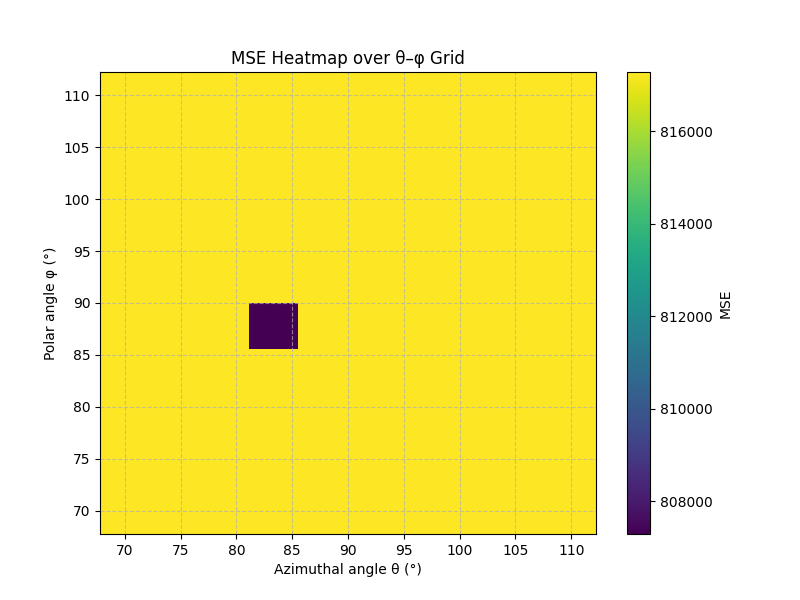

Time taken for initialization: 0.13 seconds


interactive(children=(IntSlider(value=10, description='Axial Slice', max=19), Output()), _dom_classes=('widget…

<function __main__.display_scrollable_slices_with_plane.<locals>.view_slice_axial(slice_index)>

interactive(children=(IntSlider(value=253, description='Coronal Slice', max=338, min=168), Output()), _dom_cla…

<function __main__.display_scrollable_slices_with_plane.<locals>.view_slice_coronal(slice_index)>

Optimization took 43.42 seconds.
Optimized parameters: 89.63519154343633, 89.46713698754944, 256.1896620276356 with MSE 150210.56


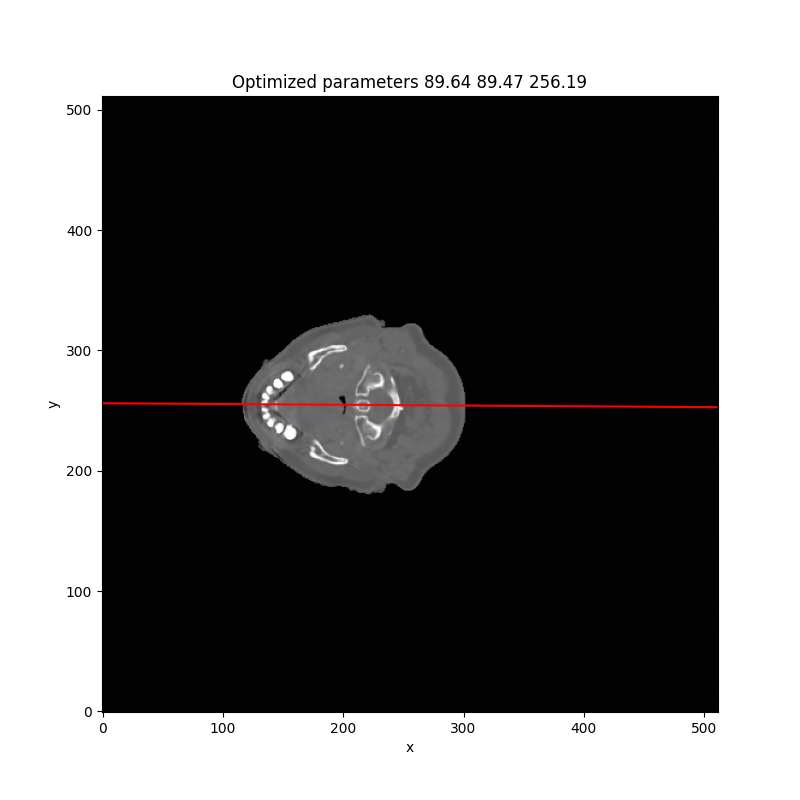

TypeError: expected str, bytes or os.PathLike object, not NoneType

In [ ]:
%matplotlib widget
#%matplotlib inline

data_path = r"/home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean"
output_path = r"/home/loriskeller/Documents/Master Project/Results/12.05.25"

MSP_pipeline(data_path, output_path, structure_names=["Image", "GTVp", "Mandible", "Spinal Cord", "Body"],
                      HU_range=[300, 1500], slice_range=None, azimuthal_deg=90, polar_deg=90, uncertainty = 20, initialization_steps=10)